In [ ]:
import numpy as np
import pandas as pd
import tensorflow
import matplotlib.pyplot as plt

import zipfile

from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout, UpSampling2D, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
print(os.listdir("../input/humpback-whale-identification/"))

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

2024-04-25 22:31:22.576079: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 22:31:22.576172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 22:31:22.737100: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


['sample_submission.csv', 'train.csv', 'test', 'train']


In [ ]:
# Читаем csv файл для train датасета
train = pd.read_csv("../input/humpback-whale-identification/train.csv")

In [ ]:
# Посмотрим статистику
train.describe()

,Image,Id
count,25361,25361
unique,25361,5005
top,fffde072b.jpg,new_whale
freq,1,9664


In [ ]:
# Посмотрим первые 5 элементов
train.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [ ]:
# Разделим Id китов и их изображения
y_train = train["Id"]
xtrain = train.drop(labels = ["Id"], axis = 1)
y_train.head()

0    w_f48451c
1    w_c3d896a
2    w_20df2c5
3    new_whale
4    new_whale
Name: Id, dtype: object

In [ ]:
def prepareImages(train, shape, path):

    x_train = np.zeros((shape, 100, 100, 3))
    count = 0

    for fig in train['Image']:

        #Загрузим изображения с форматом 100x100x3

        image = tensorflow.io.read_file("../input/humpback-whale-identification/"+path+"/"+fig)
        x = tensorflow.image.decode_jpeg(image, channels = 3)
        x = tensorflow.image.resize(x, [100,100])
        x = preprocess_input(x)
        x = x / 225

        x_train[count] = x
        if (count%5000 == 0):
            print("Processing image: ", count, ", ", fig)
        count += 1

    return x_train

In [ ]:
x_train = prepareImages(train, train.shape[0], "train")

Processing image:  0 ,  0000e88ab.jpg
Processing image:  5000 ,  3347515d9.jpg
Processing image:  10000 ,  654951f81.jpg
Processing image:  15000 ,  97079398e.jpg
Processing image:  20000 ,  c960111d0.jpg
Processing image:  25000 ,  fc09f2302.jpg


In [ ]:
print("xtrain shape: ",x_train.shape)

xtrain shape:  (25361, 100, 100, 3)


In [ ]:
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_train

array([4786, 3808,  662, ..., 3671, 3103,    0])

In [ ]:
y_train = to_categorical(y_train, num_classes = 5005)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2024)

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images horizontally
        vertical_flip=False)  # randomly flip images vertically


datagen.fit(x_train)


In [ ]:
x_train = tensorflow.convert_to_tensor(x_train)
y_train = tensorflow.convert_to_tensor(y_train)
x_val = tensorflow.convert_to_tensor(x_val)
y_val = tensorflow.convert_to_tensor(y_val)

In [ ]:
train_dataset = tensorflow.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(128)

val_dataset = tensorflow.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.shuffle(len(train_dataset)).batch(1)

In [ ]:
# Next Generation Loss function
class NGL(tensorflow.keras.losses.Loss):
    def __init__(
    	self,
    	scaling=False,
    	name="ngl_loss"):
        super().__init__(name=name)
        self.name = name
        self.scaling = scaling

    def call(self, y_true, y_pred):
        y_true = tensorflow.cast(y_true, tensorflow.float32)
        y_pred = tensorflow.cast(y_pred, tensorflow.float32)
        if self.scaling == True:
	 	        y_pred = tensorflow.math.sigmoid(y_pred)
        part_1 = tensorflow.math.exp(2.4092 - y_pred - y_pred*y_true)
        part_2 = tensorflow.math.cos(tensorflow.math.cos(tensorflow.math.sin(y_pred)))
        elements = part_1 - part_2
        loss = tensorflow.reduce_mean(elements)
        return loss

In [ ]:
model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu', input_shape = (100,100,3)))
model.add(Conv2D(filters = 16, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
model.add(MaxPool2D(pool_size = (2,2), strides=(2,2)))
model.add(BatchNormalization())

# fully connected
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dense(y_train.shape[1], activation = "softmax"))



In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5005)           │     1,286,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,719,261 (14.19 MB)

 Trainable params: 3,718,589 (14.19 MB)

 Non-trainable params: 672 (2.62 KB)

In [ ]:
model.compile(optimizer = 'adam', loss = NGL(scaling=True), metrics=["accuracy"])

In [ ]:
filename = 'supplementary.csv'
csv_logger = CSVLogger(filename)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=5, min_lr=1e-4)

history = model.fit(datagen.flow(x_train, y_train, batch_size=128),
                              epochs=100, verbose = 1,
                              validation_data=val_dataset,
                              callbacks=[reduce_lr, csv_logger])

Epoch 1/100
  2/179 ━━━━━━━━━━━━━━━━━━━━ 14s 85ms/step - accuracy: 0.0000e+00 - loss: 6.1153   

I0000 00:00:1714084711.266869     113 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714084711.292441     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/179 ━━━━━━━━━━━━━━━━━━━━ 12s 380ms/step - accuracy: 4.4255e-04 - loss: 6.1153

W0000 00:00:1714084766.323226     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 397ms/step - accuracy: 8.9757e-04 - loss: 6.1153 - val_accuracy: 0.0000e+00 - val_loss: 6.1152 - learning_rate: 0.0010
Epoch 2/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 58s 313ms/step - accuracy: 0.0513 - loss: 6.1153 - val_accuracy: 0.0000e+00 - val_loss: 6.1152 - learning_rate: 0.0010
Epoch 3/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 315ms/step - accuracy: 0.1747 - loss: 6.1153 - val_accuracy: 0.2814 - val_loss: 6.1152 - learning_rate: 0.0010
Epoch 4/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 316ms/step - accuracy: 0.2645 - loss: 6.1153 - val_accuracy: 3.9417e-04 - val_loss: 6.1152 - learning_rate: 0.0010
Epoch 5/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 318ms/step - accuracy: 0.2843 - loss: 6.1153 - val_accuracy: 7.8833e-04 - val_loss: 6.1152 - learning_rate: 0.0010
Epoch 6/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 59s 317ms/step - accuracy: 0.2917 - loss: 6.1153 - val_accuracy: 0.2818 - val_loss: 6.1152 - learning_rate: 0.0010
Epoch 7/100
179/179 ━━━━━━━━━━━━━━━━━━━━ 58s 314ms/step 

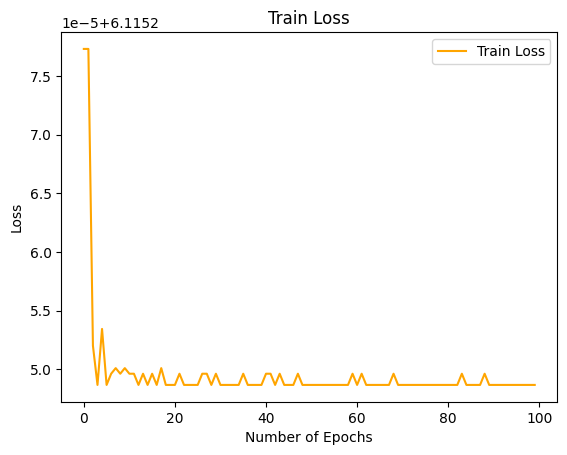

In [ ]:
# Plot the loss curve for training
plt.plot(history.history['loss'], color='orange', label="Train Loss")
plt.title("Train Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

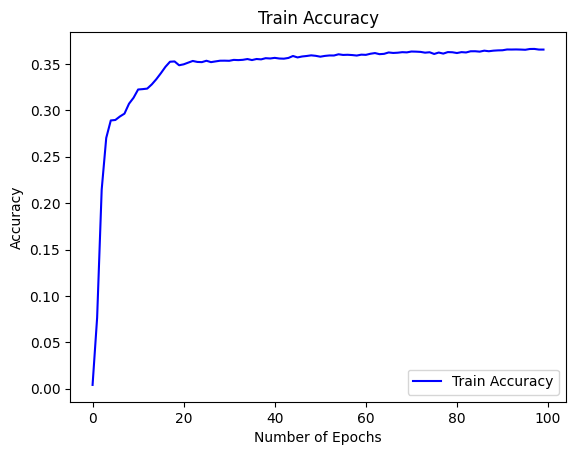

In [ ]:
# Plot the accuracy curve for training
plt.plot(history.history['accuracy'], color='blue', label="Train Accuracy")
plt.title("Train Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
print('Train accuracy of the model: ',history.history['accuracy'][-1])

Train accuracy of the model:  0.36553627252578735


In [ ]:
print('Train loss of the model: ',history.history['loss'][-1])

Train loss of the model:  6.115248680114746


In [ ]:
model.save('model1.h5')